# SHAP

### Clasificación de eventos usando SHAP como seleccionador de características con los set de datos reducidos a 818238 eventos.

-------------------------------------------------------------------------------------------------------------------------------

Alex Toro, Raquel Pezoa

## Librerias necesarias-
-------------------------------------------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import shap
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
import xgboost as xgb

In [4]:
import winsound

In [5]:
shap.initjs()

## Lectura del set de datos reducido.

- El set original proviene de https://www.kaggle.com/competitions/higgs-boson/data.
- Separación de la variable Label de las demas variables.
-------------------------------------------------------------------------------------------------------------------------------

In [6]:
df = pd.read_csv("/Users/Alex/Downloads/Pre-procesado_completo-EventID.csv")
Reducido_X_train = pd.read_csv("/Users/Alex/Downloads/Valores-X_TrainR.csv")
#colocar la direcciondel archivo

In [7]:
X = df.drop(labels=['Label'], axis=1)
Y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [8]:
X_test.shape

(163648, 31)

In [9]:
len(X_test['EventId'])


163648

In [10]:
X_testTemp = X_test.copy() #datos de testing del conjunto grande.

X_testTemp

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
59024,159024,106.530,65.749,63.599,144.152,-999.000,-999.000,-999.000,1.596,0.786,...,-2.988,240.991,1,143.764,-1.086,0.417,-999.000,-999.000,-999.000,143.764
136820,236820,87.263,31.403,69.194,112.327,3.578,256.089,-2.175,1.215,37.815,...,2.326,270.068,2,49.912,-2.802,-2.667,37.705,0.776,-1.745,87.616
746100,846100,111.784,24.642,86.294,92.428,-999.000,-999.000,-999.000,2.341,2.483,...,-2.420,241.046,1,93.925,-0.622,1.108,-999.000,-999.000,-999.000,93.925
434878,534878,148.929,42.176,102.889,159.921,-999.000,-999.000,-999.000,1.670,26.665,...,1.379,262.156,1,141.307,1.747,-1.500,-999.000,-999.000,-999.000,141.307
616295,716295,138.258,67.402,58.106,65.591,-999.000,-999.000,-999.000,2.534,0.655,...,-1.313,100.902,1,66.229,1.246,1.501,-999.000,-999.000,-999.000,66.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366905,466905,206.590,9.849,121.397,51.279,1.521,94.102,-0.479,2.852,3.085,...,0.485,174.911,2,42.361,1.075,-0.702,38.342,-0.446,-2.555,80.703
537758,637758,-999.000,74.348,31.091,3.812,-999.000,-999.000,-999.000,1.102,3.812,...,1.792,87.555,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
17811,117811,107.040,0.038,65.154,228.686,-999.000,-999.000,-999.000,1.271,29.406,...,-0.057,345.898,1,199.433,1.785,3.018,-999.000,-999.000,-999.000,199.433
557258,657258,106.543,72.027,74.932,5.849,-999.000,-999.000,-999.000,2.690,5.849,...,2.353,159.519,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000


In [11]:
X_test

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
59024,159024,106.530,65.749,63.599,144.152,-999.000,-999.000,-999.000,1.596,0.786,...,-2.988,240.991,1,143.764,-1.086,0.417,-999.000,-999.000,-999.000,143.764
136820,236820,87.263,31.403,69.194,112.327,3.578,256.089,-2.175,1.215,37.815,...,2.326,270.068,2,49.912,-2.802,-2.667,37.705,0.776,-1.745,87.616
746100,846100,111.784,24.642,86.294,92.428,-999.000,-999.000,-999.000,2.341,2.483,...,-2.420,241.046,1,93.925,-0.622,1.108,-999.000,-999.000,-999.000,93.925
434878,534878,148.929,42.176,102.889,159.921,-999.000,-999.000,-999.000,1.670,26.665,...,1.379,262.156,1,141.307,1.747,-1.500,-999.000,-999.000,-999.000,141.307
616295,716295,138.258,67.402,58.106,65.591,-999.000,-999.000,-999.000,2.534,0.655,...,-1.313,100.902,1,66.229,1.246,1.501,-999.000,-999.000,-999.000,66.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366905,466905,206.590,9.849,121.397,51.279,1.521,94.102,-0.479,2.852,3.085,...,0.485,174.911,2,42.361,1.075,-0.702,38.342,-0.446,-2.555,80.703
537758,637758,-999.000,74.348,31.091,3.812,-999.000,-999.000,-999.000,1.102,3.812,...,1.792,87.555,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
17811,117811,107.040,0.038,65.154,228.686,-999.000,-999.000,-999.000,1.271,29.406,...,-0.057,345.898,1,199.433,1.785,3.018,-999.000,-999.000,-999.000,199.433
557258,657258,106.543,72.027,74.932,5.849,-999.000,-999.000,-999.000,2.690,5.849,...,2.353,159.519,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000


In [12]:
Reducido_X_train

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,288126,93.006,10.659,62.099,362.070,3.696,1153.352,-3.394,0.801,63.874,...,-1.858,716.958,3,206.255,-1.991,1.301,167.459,1.704,1.706,412.573
1,560337,200.846,71.571,136.744,10.720,-999.000,-999.000,-999.000,3.534,10.720,...,1.035,164.981,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
2,191441,132.315,64.473,96.538,55.634,-999.000,-999.000,-999.000,2.572,2.275,...,1.973,182.737,1,53.473,-0.572,-0.312,-999.000,-999.000,-999.000,53.473
3,382301,162.959,36.183,119.743,0.542,-999.000,-999.000,-999.000,3.470,0.542,...,-0.373,86.826,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,100070,120.253,30.144,82.176,38.736,3.918,407.579,-3.457,2.551,46.301,...,-0.788,337.559,3,59.401,1.342,-0.369,53.711,-2.577,2.140,162.577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,679076,97.624,65.700,77.015,31.254,-999.000,-999.000,-999.000,3.076,1.377,...,1.483,94.651,1,31.717,-0.241,-2.613,-999.000,-999.000,-999.000,31.717
79996,739079,103.548,53.392,83.388,87.827,1.613,148.392,1.174,1.522,0.608,...,2.008,259.694,2,75.383,0.544,-0.128,51.906,2.157,1.532,127.289
79997,530946,-999.000,68.387,84.669,1.191,-999.000,-999.000,-999.000,2.381,1.191,...,1.521,116.142,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
79998,197975,83.656,38.890,54.399,24.514,-999.000,-999.000,-999.000,2.677,24.514,...,-1.195,79.173,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000


In [13]:
EventId_Grande = X_test["EventId"].values

In [14]:
print(EventId_Grande)

[159024 236820 846100 ... 117811 657258 180908]


In [15]:
l_EventId = []
for i in Reducido_X_train['EventId']:
    if(i in EventId_Grande):
        l_EventId.append(i)

In [16]:
print(l_EventId)

[100070, 714985, 606508, 857983, 256384, 478350, 212123, 744195, 481776, 908346, 616475, 361191, 799774, 472747, 795351, 540744, 769956, 736369, 776627, 203730, 835621, 487589, 605166, 182371, 803091, 141224, 714541, 879560, 625581, 507265, 205324, 582565, 559742, 120080, 725020, 448615, 548112, 549892, 728532, 908537, 848707, 542118, 582769, 889164, 378124, 561683, 867552, 735278, 759584, 850174, 819545, 504771, 483765, 886071, 208121, 312186, 381655, 836426, 243269, 880924, 592350, 876624, 725594, 694622, 840946, 399056, 337210, 637555, 806810, 441481, 888052, 125465, 581190, 246468, 763814, 774665, 386763, 708916, 436022, 730713, 571097, 164461, 837345, 481925, 626641, 357232, 382659, 526332, 877400, 183445, 608972, 841364, 624024, 646425, 743211, 638605, 707533, 324713, 821108, 241334, 460770, 472993, 540433, 193211, 291822, 858505, 446279, 442791, 623939, 345617, 581647, 866105, 232236, 622466, 736173, 397732, 635342, 226987, 665822, 264531, 135194, 260630, 755813, 683864, 182218,

In [17]:
print(len(l_EventId))

15857


In [18]:
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [19]:
l_EventId_Copia = l_EventId 

for k in l_EventId_Copia:
    suma = 0
    tamaño = 0
    for j in l_EventId_Copia:
        if(k == j):
            suma = suma+1
            #cant_list.append(suma)
            if(suma > 1):
                l_EventId.pop(tamaño)
        tamaño = tamaño + 1
print(len(l_EventId))
winsound.Beep(frequency, duration)

15119


In [20]:
print(len(l_EventId))
l_EventId[len(l_EventId)-1]

15119


197975

In [21]:
for i in l_EventId:
    #X_testTemp = X_testTemp.loc[X_testTemp['EventId'] != i, :]
    X_testTemp=X_testTemp.drop(X_testTemp[X_testTemp['EventId']==i].index)

In [22]:
X_testTemp.shape

(148529, 31)

In [23]:
X_test.shape

(163648, 31)

In [24]:
Reducido_X_train.shape

(80000, 31)

In [25]:
X

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,41.928,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
1,100001,160.937,68.768,103.235,48.146,-999.000,-999.000,-999.000,3.473,2.078,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.000,-999.000,46.226
2,100002,-999.000,162.172,125.953,35.635,-999.000,-999.000,-999.000,3.148,9.336,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.000,-999.000,44.251
3,100003,143.905,81.417,80.943,0.414,-999.000,-999.000,-999.000,3.310,0.414,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
4,100004,175.864,16.915,134.805,16.405,-999.000,-999.000,-999.000,3.891,16.405,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,156.191,0.403,47.746,0.936,1.279,6.133,...,2.273,303.668,2,112.264,1.190,-0.766,41.791,0.787,-1.090,154.056
818234,918234,99.294,30.097,62.713,65.861,3.312,471.319,-2.611,2.294,2.889,...,1.541,266.919,2,108.698,1.293,-0.868,70.158,-2.018,2.893,178.856
818235,918235,108.497,9.837,65.149,18.006,-999.000,-999.000,-999.000,2.742,18.006,...,-2.064,188.648,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
818236,918236,96.711,20.006,66.942,29.761,-999.000,-999.000,-999.000,2.479,2.739,...,-0.511,212.565,1,30.863,1.460,2.637,-999.000,-999.000,-999.000,30.863


In [26]:
winsound.Beep(frequency, duration)

In [27]:
X_train = X_train.drop(labels=['EventId'], axis=1)
X_test = X_test.drop(labels=['EventId'], axis=1)
X_testTemp = X_testTemp.drop(labels=['EventId'], axis=1)

In [28]:
X_train

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
467985,83.781,16.962,61.032,20.794,-999.000,-999.000,-999.000,2.950,20.794,61.246,...,-1.210,98.963,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
36108,135.412,10.231,100.071,115.043,0.618,53.018,-0.094,1.825,3.747,218.472,...,2.108,347.154,2,70.496,0.272,-1.801,45.621,-0.346,-1.209,116.117
375618,207.043,63.584,70.775,107.987,4.439,786.133,-4.309,2.725,74.655,242.786,...,-2.212,343.444,2,95.026,1.434,1.760,74.915,-3.005,-1.057,169.941
17344,-999.000,71.325,53.668,1.464,-999.000,-999.000,-999.000,2.229,1.464,63.083,...,2.714,58.261,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
662633,133.634,1.538,93.261,174.819,4.095,774.685,-2.875,1.610,5.608,341.757,...,-2.553,427.927,2,126.939,-0.900,0.030,79.796,3.196,1.080,206.735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,62.888,62.339,59.400,1.176,-999.000,-999.000,-999.000,2.394,1.176,63.493,...,-1.365,74.853,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
152315,136.025,8.776,79.531,146.957,4.576,651.933,-5.002,1.539,3.189,265.062,...,-0.558,368.953,2,108.436,1.805,2.966,41.128,-2.771,-3.043,149.565
117952,-999.000,74.067,54.118,5.467,-999.000,-999.000,-999.000,2.307,5.467,63.356,...,0.381,47.030,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
435829,271.436,96.925,231.481,246.450,0.474,373.836,-0.006,2.837,38.553,733.328,...,-0.092,814.676,3,308.652,-0.461,1.145,111.145,0.013,-2.437,462.512


In [32]:
model = xgb.Booster()
model.load_model("SHAP-XGBoostClassifier.model") #intentar probar porque no funciona con el modelo que viene de EventId.

### SHAP seleccionado características.

In [33]:
# Fits the explainer
explainer = shap.TreeExplainer(model = model)
# Calculates the SHAP values - It takes some time

In [34]:
# Evaluate SHAP values
shap_values = explainer.shap_values(X_testTemp)

In [35]:
X_testTemp

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
59024,106.530,65.749,63.599,144.152,-999.000,-999.000,-999.000,1.596,0.786,224.347,...,-2.988,240.991,1,143.764,-1.086,0.417,-999.000,-999.000,-999.000,143.764
136820,87.263,31.403,69.194,112.327,3.578,256.089,-2.175,1.215,37.815,196.755,...,2.326,270.068,2,49.912,-2.802,-2.667,37.705,0.776,-1.745,87.616
746100,111.784,24.642,86.294,92.428,-999.000,-999.000,-999.000,2.341,2.483,204.372,...,-2.420,241.046,1,93.925,-0.622,1.108,-999.000,-999.000,-999.000,93.925
616295,138.258,67.402,58.106,65.591,-999.000,-999.000,-999.000,2.534,0.655,128.326,...,-1.313,100.902,1,66.229,1.246,1.501,-999.000,-999.000,-999.000,66.229
72673,91.290,73.187,48.847,46.403,-999.000,-999.000,-999.000,2.249,2.658,99.518,...,-2.801,112.222,1,44.824,-1.200,-0.165,-999.000,-999.000,-999.000,44.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366905,206.590,9.849,121.397,51.279,1.521,94.102,-0.479,2.852,3.085,177.391,...,0.485,174.911,2,42.361,1.075,-0.702,38.342,-0.446,-2.555,80.703
537758,-999.000,74.348,31.091,3.812,-999.000,-999.000,-999.000,1.102,3.812,57.023,...,1.792,87.555,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
17811,107.040,0.038,65.154,228.686,-999.000,-999.000,-999.000,1.271,29.406,319.964,...,-0.057,345.898,1,199.433,1.785,3.018,-999.000,-999.000,-999.000,199.433
557258,106.543,72.027,74.932,5.849,-999.000,-999.000,-999.000,2.690,5.849,79.432,...,2.353,159.519,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000


In [36]:
shap_values

array([[-8.8661060e-02, -3.0879903e-01,  6.7861363e-02, ...,
         2.4766464e-02, -2.2226499e-02,  1.3980359e-01],
       [-1.1982274e+00,  1.3612166e-01, -1.4522345e-01, ...,
        -1.6376104e-02, -2.8787842e-02,  1.0482255e-02],
       [ 6.2381864e-01,  2.5074303e-01,  2.4966939e-01, ...,
        -1.0599016e-03, -2.3629938e-03,  1.6033037e-01],
       ...,
       [ 2.8122127e-01,  1.8750966e-01,  1.4696988e-01, ...,
        -4.0530037e-02,  4.5601600e-03,  2.0825572e-01],
       [ 2.5380558e-01, -8.5764492e-01,  1.6793375e-01, ...,
         1.8961379e-02,  1.8774932e-03, -8.5640892e-02],
       [-8.9737940e-01,  4.4935554e-01, -5.3713769e-01, ...,
         1.5935259e-02, -1.4819335e-02, -2.0257686e-01]], dtype=float32)

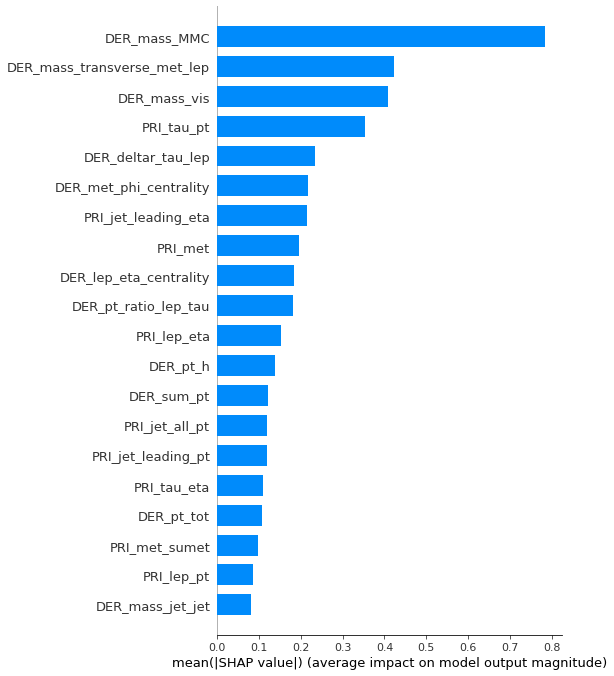

In [37]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Obteniendo la media de los valores absolutos de SHAP (|SHAP value|).
-------------------------------------------------------------------------------------------------------------------------------

In [38]:
meanL = []
for valus in range(0,len(shap_values)):
    for singularidad in range(0,len(shap_values[valus])):
        if valus==0:
            meanL.append(abs(shap_values[valus][singularidad]))
        else:
            meanL[singularidad]=meanL[singularidad]+abs(shap_values[valus][singularidad])

In [39]:
winsound.Beep(frequency, duration)

### Convertir los datos a  una lista de duplas.

- Se convierte la media de los valores absolutos de SHAP junto a las columnas del dataframe en una lista de duplas.
- Se realizan las duplas para así poder reordenar las variables de la más relevante a la menos relevante.
- Se Reordena la duplas de mayor a menor.
- Se separan las duplas en listas separadas y transformar las 20 primeras en arreglos de numpy.
-------------------------------------------------------------------------------------------------------------------------------

In [40]:
meanL=list(map(lambda x: x / len(shap_values), meanL))
l=[]
for feature in zip(meanL,X_train.columns):
    l.append(feature)
    print(feature)

(0.7846990844380559, 'DER_mass_MMC')
(0.4220452108679113, 'DER_mass_transverse_met_lep')
(0.4073780677931582, 'DER_mass_vis')
(0.13912589776238984, 'DER_pt_h')
(0.06273366517439355, 'DER_deltaeta_jet_jet')
(0.08132090497689004, 'DER_mass_jet_jet')
(0.06522242052688364, 'DER_prodeta_jet_jet')
(0.23375098991611065, 'DER_deltar_tau_lep')
(0.10722615354156427, 'DER_pt_tot')
(0.12216439266490045, 'DER_sum_pt')
(0.18190440976593797, 'DER_pt_ratio_lep_tau')
(0.21688292721875863, 'DER_met_phi_centrality')
(0.18358662281439989, 'DER_lep_eta_centrality')
(0.35235261821765446, 'PRI_tau_pt')
(0.10885200001977728, 'PRI_tau_eta')
(0.07222915406040234, 'PRI_tau_phi')
(0.08440999421830081, 'PRI_lep_pt')
(0.15306350369708946, 'PRI_lep_eta')
(0.06896268074121889, 'PRI_lep_phi')
(0.19640302514576277, 'PRI_met')
(0.06674301609450006, 'PRI_met_phi')
(0.09813091135611564, 'PRI_met_sumet')
(0.03275993437624134, 'PRI_jet_num')
(0.11865710726103994, 'PRI_jet_leading_pt')
(0.21500017988911257, 'PRI_jet_leading_

In [41]:
l.sort(reverse=True)
l

[(0.7846990844380559, 'DER_mass_MMC'),
 (0.4220452108679113, 'DER_mass_transverse_met_lep'),
 (0.4073780677931582, 'DER_mass_vis'),
 (0.35235261821765446, 'PRI_tau_pt'),
 (0.23375098991611065, 'DER_deltar_tau_lep'),
 (0.21688292721875863, 'DER_met_phi_centrality'),
 (0.21500017988911257, 'PRI_jet_leading_eta'),
 (0.19640302514576277, 'PRI_met'),
 (0.18358662281439989, 'DER_lep_eta_centrality'),
 (0.18190440976593797, 'DER_pt_ratio_lep_tau'),
 (0.15306350369708946, 'PRI_lep_eta'),
 (0.13912589776238984, 'DER_pt_h'),
 (0.12216439266490045, 'DER_sum_pt'),
 (0.11893422591295302, 'PRI_jet_all_pt'),
 (0.11865710726103994, 'PRI_jet_leading_pt'),
 (0.10885200001977728, 'PRI_tau_eta'),
 (0.10722615354156427, 'DER_pt_tot'),
 (0.09813091135611564, 'PRI_met_sumet'),
 (0.08440999421830081, 'PRI_lep_pt'),
 (0.08132090497689004, 'DER_mass_jet_jet'),
 (0.07222915406040234, 'PRI_tau_phi'),
 (0.06896268074121889, 'PRI_lep_phi'),
 (0.06674301609450006, 'PRI_met_phi'),
 (0.06522242052688364, 'DER_prodeta_

In [42]:
l_v = ['EventId']
for importance in range(len(l)):
    for var in range(len(l[importance])):
        if(var == 1):
            l_v.append(l[importance][var])
            

In [43]:
winsound.Beep(frequency, duration)

In [44]:
x = np.array(l_v[0:21])

In [45]:
X_BestFeature = X[x]
X_BestFeature

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,PRI_tau_pt,DER_deltar_tau_lep,DER_met_phi_centrality,PRI_jet_leading_eta,PRI_met,DER_lep_eta_centrality,...,PRI_lep_eta,DER_pt_h,DER_sum_pt,PRI_jet_all_pt,PRI_jet_leading_pt,PRI_tau_eta,DER_pt_tot,PRI_met_sumet,PRI_lep_pt,DER_mass_jet_jet
0,100000,138.470,51.655,97.827,32.638,3.064,1.396,2.150,16.824,0.200,...,2.273,27.980,197.760,113.497,67.435,1.017,41.928,258.733,51.626,124.711
1,100001,160.937,68.768,103.235,42.014,3.473,1.414,0.725,44.704,-999.000,...,0.501,48.146,125.157,46.226,46.226,2.039,2.078,164.546,36.918,-999.000
2,100002,-999.000,162.172,125.953,32.154,3.148,1.414,2.053,54.283,-999.000,...,-0.953,35.635,197.814,44.251,44.251,-0.705,9.336,260.414,121.409,-999.000
3,100003,143.905,81.417,80.943,22.647,3.310,-1.285,-999.000,31.082,-999.000,...,-0.522,0.414,75.968,-0.000,-999.000,-1.655,0.414,86.062,53.321,-999.000
4,100004,175.864,16.915,134.805,28.209,3.891,-1.385,-999.000,2.723,-999.000,...,0.798,16.405,57.983,0.000,-999.000,-2.197,16.405,53.131,29.774,-999.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818233,918233,105.668,46.443,60.048,61.970,1.279,1.343,1.190,72.892,0.000,...,2.098,156.191,256.853,154.056,112.264,2.074,6.133,303.668,40.827,47.746
818234,918234,99.294,30.097,62.713,28.711,2.294,1.398,1.293,34.940,0.586,...,-1.573,65.861,248.582,178.856,108.698,-1.724,2.889,266.919,41.015,471.319
818235,918235,108.497,9.837,65.149,41.478,2.742,-0.836,-999.000,30.463,-999.000,...,1.087,18.006,68.097,-0.000,-999.000,1.057,18.006,188.648,26.619,-999.000
818236,918236,96.711,20.006,66.942,36.575,2.479,1.410,1.460,6.647,-999.000,...,-1.216,29.761,101.676,30.863,30.863,-1.249,2.739,212.565,34.238,-999.000


### Entrenamiento, testeo y optimizacion de parametros de DMatrix de XGBoost con las variables entregadas por SHAP.
-------------------------------------------------------------------------------------------------------------------------------

In [46]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_BestFeature, Y, test_size=0.2, random_state=0)

In [48]:
Reducido_X_train2 = pd.read_csv("/Users/Alex/Downloads/Valores-X_Train2R.csv")

In [49]:
X_test2.shape

(163648, 21)

In [50]:
len(X_test2['EventId'])


163648

In [51]:
X_testTemp2 = X_test2.copy() #datos de testing del conjunto grande.

X_testTemp2

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,PRI_tau_pt,DER_deltar_tau_lep,DER_met_phi_centrality,PRI_jet_leading_eta,PRI_met,DER_lep_eta_centrality,...,PRI_lep_eta,DER_pt_h,DER_sum_pt,PRI_jet_all_pt,PRI_jet_leading_pt,PRI_tau_eta,DER_pt_tot,PRI_met_sumet,PRI_lep_pt,DER_mass_jet_jet
59024,159024,106.530,65.749,63.599,42.803,1.596,0.940,-1.086,84.171,-999.00,...,-0.051,144.152,224.347,143.764,143.764,-1.116,0.786,240.991,37.780,-999.000
136820,236820,87.263,31.403,69.194,64.830,1.215,0.009,-2.802,14.133,0.89,...,-0.402,112.327,196.755,87.616,49.912,0.810,37.815,270.068,44.309,256.089
746100,846100,111.784,24.642,86.294,21.856,2.341,1.377,-0.622,15.995,-999.00,...,-2.229,92.428,204.372,93.925,93.925,-1.437,2.483,241.046,88.591,-999.000
434878,534878,148.929,42.176,102.889,45.610,1.670,1.410,1.747,52.065,-999.00,...,-1.388,159.921,277.078,141.307,141.307,-2.331,26.665,262.156,90.161,-999.000
616295,716295,138.258,67.402,58.106,23.759,2.534,1.396,1.246,51.360,-999.00,...,-0.378,65.591,128.326,66.229,66.229,-0.093,0.655,100.902,38.338,-999.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366905,466905,206.590,9.849,121.397,65.153,2.852,0.506,1.075,44.551,0.00,...,-2.265,51.279,177.391,80.703,42.361,-0.519,3.085,174.911,31.535,94.102
537758,637758,-999.000,74.348,31.091,30.490,1.102,-1.412,-999.000,54.174,-999.00,...,-1.739,3.812,57.023,0.000,-999.000,-2.445,3.812,87.555,26.533,-999.000
17811,117811,107.040,0.038,65.154,24.923,1.271,0.999,1.785,110.873,-999.00,...,-2.291,228.686,319.964,199.433,199.433,-1.122,29.406,345.898,95.608,-999.000
557258,657258,106.543,72.027,74.932,27.723,2.690,-1.308,-999.000,25.637,-999.00,...,1.828,5.849,79.432,-0.000,-999.000,2.199,5.849,159.519,51.709,-999.000


In [52]:
X_test2

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,PRI_tau_pt,DER_deltar_tau_lep,DER_met_phi_centrality,PRI_jet_leading_eta,PRI_met,DER_lep_eta_centrality,...,PRI_lep_eta,DER_pt_h,DER_sum_pt,PRI_jet_all_pt,PRI_jet_leading_pt,PRI_tau_eta,DER_pt_tot,PRI_met_sumet,PRI_lep_pt,DER_mass_jet_jet
59024,159024,106.530,65.749,63.599,42.803,1.596,0.940,-1.086,84.171,-999.00,...,-0.051,144.152,224.347,143.764,143.764,-1.116,0.786,240.991,37.780,-999.000
136820,236820,87.263,31.403,69.194,64.830,1.215,0.009,-2.802,14.133,0.89,...,-0.402,112.327,196.755,87.616,49.912,0.810,37.815,270.068,44.309,256.089
746100,846100,111.784,24.642,86.294,21.856,2.341,1.377,-0.622,15.995,-999.00,...,-2.229,92.428,204.372,93.925,93.925,-1.437,2.483,241.046,88.591,-999.000
434878,534878,148.929,42.176,102.889,45.610,1.670,1.410,1.747,52.065,-999.00,...,-1.388,159.921,277.078,141.307,141.307,-2.331,26.665,262.156,90.161,-999.000
616295,716295,138.258,67.402,58.106,23.759,2.534,1.396,1.246,51.360,-999.00,...,-0.378,65.591,128.326,66.229,66.229,-0.093,0.655,100.902,38.338,-999.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366905,466905,206.590,9.849,121.397,65.153,2.852,0.506,1.075,44.551,0.00,...,-2.265,51.279,177.391,80.703,42.361,-0.519,3.085,174.911,31.535,94.102
537758,637758,-999.000,74.348,31.091,30.490,1.102,-1.412,-999.000,54.174,-999.00,...,-1.739,3.812,57.023,0.000,-999.000,-2.445,3.812,87.555,26.533,-999.000
17811,117811,107.040,0.038,65.154,24.923,1.271,0.999,1.785,110.873,-999.00,...,-2.291,228.686,319.964,199.433,199.433,-1.122,29.406,345.898,95.608,-999.000
557258,657258,106.543,72.027,74.932,27.723,2.690,-1.308,-999.000,25.637,-999.00,...,1.828,5.849,79.432,-0.000,-999.000,2.199,5.849,159.519,51.709,-999.000


In [53]:
Reducido_X_train2

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,PRI_tau_pt,DER_deltar_tau_lep,DER_met_phi_centrality,PRI_jet_leading_eta,PRI_met,DER_lep_eta_centrality,...,PRI_lep_eta,DER_pt_h,DER_sum_pt,PRI_jet_all_pt,PRI_jet_leading_pt,PRI_tau_eta,DER_pt_tot,PRI_met_sumet,PRI_lep_pt,DER_mass_jet_jet
0,288126,93.006,10.659,62.099,33.106,0.801,1.097,-1.991,148.161,0.863,...,0.566,362.070,633.979,412.573,206.255,0.252,63.874,716.958,188.301,1153.352
1,560337,200.846,71.571,136.744,33.480,3.534,-0.955,-999.000,23.698,-999.000,...,-0.006,10.720,87.521,0.000,-999.000,-2.123,10.720,164.981,54.041,-999.000
2,191441,132.315,64.473,96.538,68.190,2.572,-1.297,-0.572,28.908,-999.000,...,-0.818,55.634,158.490,53.473,53.473,-0.637,2.275,182.737,36.827,-999.000
3,382301,162.959,36.183,119.743,39.265,3.470,-1.411,-999.000,8.812,-999.000,...,-1.363,0.542,83.637,0.000,-999.000,0.444,0.542,86.826,44.372,-999.000
4,100070,120.253,30.144,82.176,39.923,2.551,1.400,1.342,11.126,0.434,...,1.174,38.736,243.103,162.577,59.401,1.963,46.301,337.559,40.602,407.579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,679076,97.624,65.700,77.015,23.759,3.076,-1.414,-0.241,32.409,-999.000,...,0.867,31.254,106.339,31.717,31.717,-0.072,1.377,94.651,50.864,-999.000
79996,739079,103.548,53.392,83.388,51.768,1.522,-0.351,0.544,28.268,0.253,...,0.405,87.827,236.710,127.289,75.383,1.488,0.608,259.694,57.653,148.392
79997,530946,-999.000,68.387,84.669,43.624,2.381,-1.414,-999.000,34.535,-999.000,...,-1.566,1.191,90.848,0.000,-999.000,-1.358,1.191,116.142,47.225,-999.000
79998,197975,83.656,38.890,54.399,28.443,2.677,1.203,-999.000,15.414,-999.000,...,-1.979,24.514,55.451,-0.000,-999.000,-1.706,24.514,79.173,27.008,-999.000


In [54]:
EventId_Grande2 = X_test2["EventId"].values

In [55]:
print(EventId_Grande2)

[159024 236820 846100 ... 117811 657258 180908]


In [56]:
l_EventId2 = []
for i in Reducido_X_train2['EventId']:
    if(i in EventId_Grande2):
        l_EventId2.append(i)

In [57]:
print(l_EventId2)

[100070, 714985, 606508, 857983, 256384, 478350, 212123, 744195, 481776, 908346, 616475, 361191, 799774, 472747, 795351, 540744, 769956, 736369, 776627, 203730, 835621, 487589, 605166, 182371, 803091, 141224, 714541, 879560, 625581, 507265, 205324, 582565, 559742, 120080, 725020, 448615, 548112, 549892, 728532, 908537, 848707, 542118, 582769, 889164, 378124, 561683, 867552, 735278, 759584, 850174, 819545, 504771, 483765, 886071, 208121, 312186, 381655, 836426, 243269, 880924, 592350, 876624, 725594, 694622, 840946, 399056, 337210, 637555, 806810, 441481, 888052, 125465, 581190, 246468, 763814, 774665, 386763, 708916, 436022, 730713, 571097, 164461, 837345, 481925, 626641, 357232, 382659, 526332, 877400, 183445, 608972, 841364, 624024, 646425, 743211, 638605, 707533, 324713, 821108, 241334, 460770, 472993, 540433, 193211, 291822, 858505, 446279, 442791, 623939, 345617, 581647, 866105, 232236, 622466, 736173, 397732, 635342, 226987, 665822, 264531, 135194, 260630, 755813, 683864, 182218,

In [58]:
print(len(l_EventId2))

15857


In [59]:
winsound.Beep(frequency, duration)

In [60]:
l_EventId2_Copia = l_EventId2 

for k in l_EventId2_Copia:
    suma = 0
    tamaño = 0
    for j in l_EventId2_Copia:
        if(k == j):
            suma = suma+1
            #cant_list.append(suma)
            if(suma > 1):
                l_EventId2.pop(tamaño)
        tamaño = tamaño + 1
print(len(l_EventId2))
winsound.Beep(frequency, duration)

15119


In [61]:
print(len(l_EventId2))
l_EventId2[len(l_EventId2)-1]

15119


197975

In [62]:
y_testTemp2 = y_test2.copy() #datos de testing del conjunto grande.

y_testTemp2

59024     1
136820    0
746100    1
434878    1
616295    0
         ..
366905    0
537758    0
17811     1
557258    1
80908     0
Name: Label, Length: 163648, dtype: int64

In [63]:
ind=X_testTemp2[X_testTemp2['EventId']==159024].index
xD= X_testTemp2.loc[ind.tolist()[0], 'EventId']
xD

159024

In [64]:
for i in l_EventId2:
    indexX_test2 = X_testTemp2[X_testTemp2['EventId']==i].index
    if(i == X_testTemp2['EventId'][indexX_test2.tolist()[0]]):
        y_testTemp2=y_testTemp2.drop(indexX_test2.tolist()[0])
    X_testTemp2=X_testTemp2.drop(indexX_test2)
    

In [65]:
X_testTemp2.shape

(148529, 21)

In [66]:
X_test2.shape

(163648, 21)

In [67]:
Reducido_X_train2.shape

(80000, 21)

In [68]:
winsound.Beep(frequency, duration)

In [69]:
X_train2 = X_train2.drop(labels=['EventId'], axis=1)
X_test2 = X_test2.drop(labels=['EventId'], axis=1)
X_testTemp2 = X_testTemp2.drop(labels=['EventId'], axis=1)

In [70]:
X_train2

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,PRI_tau_pt,DER_deltar_tau_lep,DER_met_phi_centrality,PRI_jet_leading_eta,PRI_met,DER_lep_eta_centrality,DER_pt_ratio_lep_tau,PRI_lep_eta,DER_pt_h,DER_sum_pt,PRI_jet_all_pt,PRI_jet_leading_pt,PRI_tau_eta,DER_pt_tot,PRI_met_sumet,PRI_lep_pt,DER_mass_jet_jet
467985,83.781,16.962,61.032,30.905,2.950,-1.397,-999.000,23.789,-999.000,0.982,2.112,20.794,61.246,0.000,-999.000,2.204,20.794,98.963,30.341,-999.000
36108,135.412,10.231,100.071,68.512,1.825,0.280,0.272,16.022,0.005,0.494,-0.750,115.043,218.472,116.117,70.496,1.056,3.747,347.154,33.843,53.018
375618,207.043,63.584,70.775,28.042,2.725,1.411,1.434,87.272,0.878,1.598,-1.585,107.987,242.786,169.941,95.026,-1.159,74.655,343.444,44.803,786.133
17344,-999.000,71.325,53.668,21.436,2.229,-1.358,-999.000,33.259,-999.000,1.943,-0.243,1.464,63.083,0.000,-999.000,-0.255,1.464,58.261,41.647,-999.000
662633,133.634,1.538,93.261,33.601,1.610,1.022,-0.900,57.963,0.959,3.018,0.729,174.819,341.757,206.735,126.939,1.812,5.608,427.927,101.422,774.685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,62.888,62.339,59.400,24.395,2.394,-1.373,-999.000,27.620,-999.000,1.603,-0.534,1.176,63.493,0.000,-999.000,-1.095,1.176,74.853,39.098,-999.000
152315,136.025,8.776,79.531,80.743,1.539,1.197,1.805,57.408,0.793,0.430,0.618,146.957,265.062,149.565,108.436,1.547,3.189,368.953,34.755,651.933
117952,-999.000,74.067,54.118,20.248,2.307,-1.368,-999.000,35.091,-999.000,2.129,1.888,5.467,63.356,0.000,-999.000,2.010,5.467,47.030,43.108,-999.000
435829,271.436,96.925,231.481,21.380,2.837,-1.130,-0.461,18.605,0.000,11.667,1.277,246.450,733.328,462.512,308.652,-0.993,38.553,814.676,249.436,373.836


In [71]:
X_testTemp2.shape

(148529, 20)

In [72]:
y_test2.shape

(163648,)

In [73]:
dtrain = xgb.DMatrix(X_train2, label=y_train2)
dtest = xgb.DMatrix(X_testTemp2, label=y_testTemp2) 

In [74]:
from sklearn.metrics import mean_absolute_error


### Carga del modelo y predicciones.
-------------------------------------------------------------------------------------------------------------------------------

In [75]:
loaded_model = xgb.Booster()
loaded_model.load_model("SHAP-20%.model")
# And use it for predictions.

[22:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [76]:
Prediccion = loaded_model.predict(dtest)

In [77]:
Prediccion.min()

-0.26798037

In [78]:
Prediccion.max()

1.2624215

In [79]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_curve, auc, roc_auc_score, ConfusionMatrixDisplay

In [80]:
testing_list =[]
for i in  np.linspace(0.1,0.9,9):
    d = {}
    y_p = Prediccion >= i
    print("Threshold:",i)
    cm = confusion_matrix(y_testTemp2,y_p)
    d["th"] = i
    d["F1"] = np.round(f1_score(y_testTemp2,y_p),2)
    d["Prec"] = np.round(precision_score(y_testTemp2,y_p),2)
    d["Rec"] = np.round(recall_score(y_testTemp2,y_p),2)
    d["Acc"] = np.round(accuracy_score(y_testTemp2,y_p),2)
    d["RocAuc"] = np.round(roc_auc_score(y_testTemp2,y_p),2)
    testing_list.append(d)

Threshold: 0.1
Threshold: 0.2
Threshold: 0.30000000000000004
Threshold: 0.4
Threshold: 0.5
Threshold: 0.6
Threshold: 0.7000000000000001
Threshold: 0.8
Threshold: 0.9


# Metricas para cada umbral.
- th: umbral
-------------------------------------------------------------------------------------------------------------------------------

In [81]:
testing_metrics_pd = pd.DataFrame(testing_list)
testing_metrics_pd

,th,F1,Prec,Rec,Acc,RocAuc
0,0.1,0.67,0.51,0.95,0.68,0.74
1,0.2,0.72,0.60,0.91,0.76,0.80
2,0.3,0.75,0.67,0.85,0.81,0.82
3,0.4,0.76,0.73,0.78,0.83,0.82
4,0.5,0.75,0.78,0.72,0.83,0.81
5,0.6,0.72,0.82,0.64,0.83,0.78
6,0.7,0.67,0.86,0.55,0.82,0.75
7,0.8,0.58,0.90,0.43,0.79,0.70
8,0.9,0.42,0.94,0.27,0.75,0.63


In [82]:
print(testing_metrics_pd.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 th &   F1 &  Prec &  Rec &  Acc &  RocAuc \\
\midrule
0.1 & 0.67 &  0.51 & 0.95 & 0.68 &    0.74 \\
0.2 & 0.72 &  0.60 & 0.91 & 0.76 &    0.80 \\
0.3 & 0.75 &  0.67 & 0.85 & 0.81 &    0.82 \\
0.4 & 0.76 &  0.73 & 0.78 & 0.83 &    0.82 \\
0.5 & 0.75 &  0.78 & 0.72 & 0.83 &    0.81 \\
0.6 & 0.72 &  0.82 & 0.64 & 0.83 &    0.78 \\
0.7 & 0.67 &  0.86 & 0.55 & 0.82 &    0.75 \\
0.8 & 0.58 &  0.90 & 0.43 & 0.79 &    0.70 \\
0.9 & 0.42 &  0.94 & 0.27 & 0.75 &    0.63 \\
\bottomrule
\end{tabular}



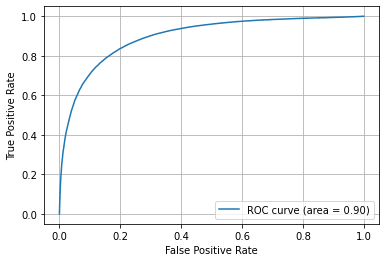

In [83]:
fpr, tpr, ths = roc_curve(y_testTemp2,  Prediccion)
auc_ = auc(fpr, tpr)
plt.plot(fpr,tpr, label='ROC curve (area = %.2f)' %auc_)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [84]:
for i in  np.linspace(0.1,0.9,9):
    print(i)
    y_p = Prediccion >= i
    print(classification_report(y_testTemp2, y_p))
    f1 = f1_score(y_testTemp2, y_p)
    prec = precision_score(y_testTemp2, y_p)
    rec = recall_score(y_testTemp2, y_p)
    acc = accuracy_score(y_testTemp2, y_p)
    cm=confusion_matrix(y_testTemp2, y_p)
    print("Matriz de confusión: ")
    print(cm)
    print("----------------------------------------------------------")
    print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)
    print("----------------------------------------------------------")

0.1
              precision    recall  f1-score   support

           0       0.96      0.53      0.69     98140
           1       0.51      0.95      0.67     50389

    accuracy                           0.68    148529
   macro avg       0.73      0.74      0.68    148529
weighted avg       0.81      0.68      0.68    148529

Matriz de confusión: 
[[52384 45756]
 [ 2327 48062]]
----------------------------------------------------------
F1: 0.67  -- prec: 0.51  -- recall: 0.95  -- acc: 0.68
----------------------------------------------------------
0.2
              precision    recall  f1-score   support

           0       0.93      0.69      0.79     98140
           1       0.60      0.91      0.72     50389

    accuracy                           0.76    148529
   macro avg       0.77      0.80      0.76    148529
weighted avg       0.82      0.76      0.77    148529

Matriz de confusión: 
[[67856 30284]
 [ 4748 45641]]
----------------------------------------------------------


In [85]:
umbral = 0.4

In [86]:
maskSignal=Prediccion>umbral

In [87]:
predicBin=[]
for i in maskSignal:
    if(i==True):
        predicBin.append(1)
    else:
        predicBin.append(0)

In [88]:
npPredict=np.array(predicBin)

In [89]:
cm=confusion_matrix(y_testTemp2, npPredict)
cm

array([[83431, 14709],
       [10851, 39538]], dtype=int64)

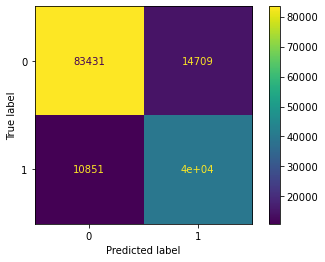

In [90]:
cm_display = ConfusionMatrixDisplay(cm).plot()

In [91]:
f1= f1_score(y_testTemp2, npPredict)
f1

0.7557246072097556

prec=precision_score(y_test2, npPredict)
prec

In [92]:
rec=recall_score(y_testTemp2, npPredict)
rec

0.7846553811347715

In [93]:
accu=accuracy_score(y_testTemp2, npPredict)
accu

0.827912394212578

In [94]:
print(classification_report(y_testTemp2, npPredict))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     98140
           1       0.73      0.78      0.76     50389

    accuracy                           0.83    148529
   macro avg       0.81      0.82      0.81    148529
weighted avg       0.83      0.83      0.83    148529



In [95]:
print("F1: %.2f" %f1 , " -- prec: %.2f" %prec, " -- recall: %.2f" %rec, " -- acc: %.2f" %acc)

F1: 0.76  -- prec: 0.94  -- recall: 0.78  -- acc: 0.75


In [96]:
winsound.Beep(frequency, duration)